In [1]:
pip install rasterio geopandas matplotlib pandas numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Loading data...
Found 27 countries to process
Reprojecting vector data to match raster CRS...

Processing countries...
Processing Austria...
Processing Belgium...
Processing Bulgaria...
Processing Cyprus...
Processing Czechia...
Processing Germany...
Processing Denmark...
Processing Estonia...
Processing Greece...
Processing Spain...
Processing Finland...
Processing France...
Processing Croatia...
Processing Hungary...
Processing Ireland...
Processing Italy...
Processing Lithuania...
Processing Luxembourg...
Processing Latvia...
Processing Malta...
Processing Netherlands...
Processing Poland...
Processing Portugal...
Processing Romania...
Processing Sweden...
Processing Slovenia...
Processing Slovakia...

Confidence Class Distribution by EU Country (% of pixels):


,Country,High Confidence %,Moderate Confidence %,Low Confidence %,Total Pixels
0,Austria,16.79,63.97,19.24,143760
1,Belgium,27.66,62.12,10.22,56775
2,Bulgaria,20.32,64.11,15.57,174651
12,Croatia,13.40,65.37,21.23,91997
3,Cyprus,30.83,47.18,21.99,12912
4,Czechia,13.69,62.38,23.94,142286
6,Denmark,18.19,69.15,12.66,86568
7,Estonia,14.58,65.79,19.63,95952
10,Finland,43.85,48.19,7.96,816939
11,France,25.02,60.87,14.11,1025493



Results saved to /home/erdoghi/LDN/GlobalData/EU/LPD_Agreement_Pixel_Stats.csv
Plot saved to /home/erdoghi/LDN/GlobalData/EU/LPD_Agreement_Pixel_Plot.png


<Figure size 1200x1000 with 0 Axes>

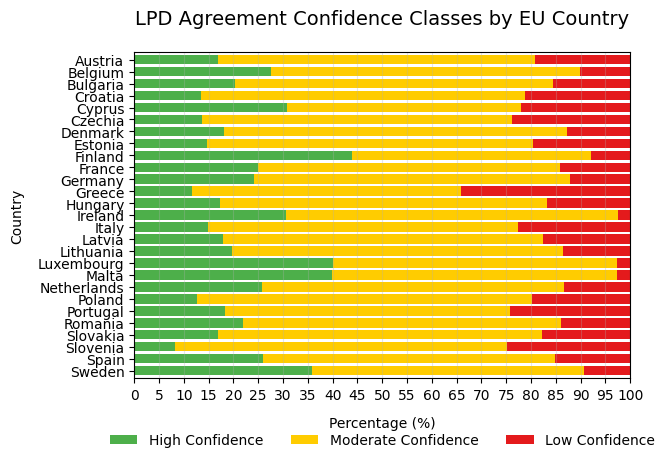

In [1]:
import rasterio
import rasterio.mask
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.geometry import box

# Set paths
raster_path = "/home/erdoghi/LDN/GlobalData/EU/LPD_2005_2019_Agreement.tif"
vector_path = "/home/erdoghi/LDN/GlobalData/gadm_EU.shp"

# Define confidence classes
class_values = {
    1: "High Confidence",
    2: "Moderate Confidence",
    3: "Low Confidence"
}

# Load data
print("Loading data...")
gdf = gpd.read_file(vector_path)

# Verify country field exists
country_field = 'NAME_ENGL'
if country_field not in gdf.columns:
    print(f"Error: Field '{country_field}' not found. Available fields:")
    print(gdf.columns.tolist())
    raise ValueError("Country field not found")

# Get unique countries
countries = gdf[country_field].unique()
print(f"Found {len(countries)} countries to process")

# Open raster and get its bounds
with rasterio.open(raster_path) as src:
    raster_bounds = src.bounds
    raster_polygon = box(*raster_bounds)
    raster_crs = src.crs

# Transform vector to raster CRS if needed
if gdf.crs != raster_crs:
    print("Reprojecting vector data to match raster CRS...")
    gdf = gdf.to_crs(raster_crs)

# Prepare results storage
results = []

# Process each country
print("\nProcessing countries...")
with rasterio.open(raster_path) as src:
    for country in countries:
        print(f"Processing {country}...")
        country_geom = gdf[gdf[country_field] == country].geometry
        
        if not country_geom.intersects(raster_polygon).any():
            print(f"  {country} does not overlap with raster")
            continue
            
        try:
            # Clip raster to country boundary
            out_image, _ = rasterio.mask.mask(src, country_geom, crop=True, all_touched=True)
            out_image = out_image[0]  # Get first band
            
            # Calculate pixel counts
            counts = {class_val: np.sum(out_image == class_val) for class_val in class_values}
            total_pixels = sum(counts.values())
            
            if total_pixels > 0:
                percentages = {
                    class_name: (counts[class_val] / total_pixels) * 100 
                    for class_val, class_name in class_values.items()
                }
            else:
                percentages = {class_name: 0 for class_name in class_values.values()}
            
            results.append({
                'Country': country,
                **{f"{class_name} %": round(percent, 2) for class_name, percent in percentages.items()},
                'Total Pixels': total_pixels
            })
            
        except Exception as e:
            print(f"  Error processing {country}: {str(e)}")

# Create DataFrame
df = pd.DataFrame(results).sort_values('Country')

# Display results
print("\nConfidence Class Distribution by EU Country (% of pixels):")
display(df)

# Prepare data for plotting - ensure proper alphabetical sorting
plot_df = df.sort_values('Country', ascending=True).set_index('Country')
confidence_cols = [col for col in plot_df.columns if '%' in col]

# Create horizontal stacked bar plot
plt.figure(figsize=(12, 10))
ax = plot_df[confidence_cols].plot.barh(
    stacked=True,
    color=['#4daf4a', '#ffcc00', '#e41a1c'],  # Green, Yellow, Red
    width=0.8
)

# Configure plot appearance
plt.title('LPD Agreement Confidence Classes by EU Country', pad=20, fontsize=14)
plt.xlabel('Percentage (%)', labelpad=10)
plt.ylabel('Country', labelpad=10)
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 5))
plt.grid(axis='x', alpha=0.3)

# Reverse Y-axis to show A at top (first in alphabetical order)
ax.invert_yaxis()

# Configure legend - moved further down to prevent overlap
plt.legend(
    bbox_to_anchor=(0.5, -0.25),  # Adjusted vertical position
    loc='lower center',
    ncol=3,
    frameon=False,
    labels=['High Confidence', 'Moderate Confidence', 'Low Confidence']
)

# Adjust layout to accommodate legend
plt.subplots_adjust(bottom=0.2)  # Increased bottom margin

# Save outputs
output_dir = Path("/home/erdoghi/LDN/GlobalData/EU")
output_dir.mkdir(parents=True, exist_ok=True)

output_csv = output_dir / "LPD_Agreement_Pixel_Stats.csv"
df.sort_values('Country', ascending=True).to_csv(output_csv, index=False)  # Ensure sorted output
print(f"\nResults saved to {output_csv}")

plot_path = output_dir / "LPD_Agreement_Pixel_Plot.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to {plot_path}")

plt.show()

In [3]:
import rasterio
import rasterio.mask
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.geometry import box

# Set paths
vector_path = "/home/erdoghi/LDN/GlobalData/gadm_EU.shp"
total_pixels_csv = "/home/erdoghi/LDN/GlobalData/EU/LPD_Agreement_Pixel_Stats.csv"
disagreement_paths = {
    'JRC': "/home/erdoghi/LDN/GlobalData/EU/Agreements/LPD_FAO_TE_agree_JRC_disagree.tif",
    'TE': "/home/erdoghi/LDN/GlobalData/EU/Agreements/LPD_JRC_FAO_agree_TE_disagree.tif",
    'FAO': "/home/erdoghi/LDN/GlobalData/EU/Agreements/LPD_JRC_TE_agree_FAO_disagree.tif"
}

# Load total pixels data
print("Loading total pixels data...")
total_pixels_df = pd.read_csv(total_pixels_csv)
country_field = 'Country'
total_field = 'Total Pixels'

# Load vector data
print("Loading vector data...")
gdf = gpd.read_file(vector_path)
vector_country_field = 'NAME_ENGL'

# Verify country field exists
if vector_country_field not in gdf.columns:
    print(f"Error: Field '{vector_country_field}' not found. Available fields:")
    print(gdf.columns.tolist())
    raise ValueError("Country field not found")

# Prepare results storage - one dictionary per country
results = {row[country_field]: {'Total_Pixels': row[total_field]} 
           for _, row in total_pixels_df.iterrows()}

# Process each disagreement source
for source, raster_path in disagreement_paths.items():
    print(f"\nProcessing {source} disagreements...")
    
    for country in results.keys():
        print(f"Processing {country}...")
        country_geom = gdf[gdf[vector_country_field] == country].geometry
        
        try:
            with rasterio.open(raster_path) as src:
                # Check CRS match
                if gdf.crs != src.crs:
                    country_geom = gdf[gdf[vector_country_field] == country].to_crs(src.crs).geometry
                
                # Clip raster to country boundary
                out_image, _ = rasterio.mask.mask(src, country_geom, crop=True, all_touched=True)
                out_image = out_image[0]  # Get first band
                
                # Count disagreement pixels (value = 1)
                count = np.sum(out_image == 1)
                percentage = (count / results[country]['Total_Pixels']) * 100 if results[country]['Total_Pixels'] > 0 else 0
                
                results[country][f'{source}_Count'] = count
                results[country][f'{source}_Percentage'] = percentage
                
        except Exception as e:
            print(f"  Error processing {country}: {str(e)}")
            results[country][f'{source}_Count'] = 0
            results[country][f'{source}_Percentage'] = 0

# Convert to DataFrame and sort alphabetically
df = pd.DataFrame.from_dict(results, orient='index').reset_index()
df = df.rename(columns={'index': 'Country'}).sort_values('Country', ascending=True)

# Save comprehensive CSV
output_dir = Path("/home/erdoghi/LDN/GlobalData/EU/Agreements")
output_dir.mkdir(parents=True, exist_ok=True)

output_csv = output_dir / "DisagreementStat.csv"
df.to_csv(output_csv, index=False)
print(f"\nComprehensive results saved to {output_csv}")

# Create separate plots for each source
for source in disagreement_paths.keys():
    plt.figure(figsize=(12, 10))
    ax = plt.gca()
    
    # Sort and plot
    plot_df = df.sort_values('Country', ascending=True)
    plot_df.plot.barh(
        x='Country',
        y=f'{source}_Percentage',
        color='red',  # Consistent blue color
        width=0.8,
        ax=ax
    )
    
    plt.title(f'{source} Disagreement Percentage by EU Country', pad=20, fontsize=14)
    plt.xlabel('Percentage of Disagreement (%)', labelpad=10)
    plt.ylabel('Country', labelpad=10)
    plt.xlim(0, 100)
    plt.xticks(np.arange(0, 101, 5))
    plt.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()  # A at top
    
    # Save plot
    plot_path = output_dir / f"{source}_LPD_Disagreement_Plot.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved to {plot_path}")
    plt.close()

print("\nAll processing complete!")

Loading total pixels data...
Loading vector data...

Processing JRC disagreements...
Processing Austria...
Processing Belgium...
Processing Bulgaria...
Processing Croatia...
Processing Cyprus...
Processing Czechia...
Processing Denmark...
Processing Estonia...
Processing Finland...
Processing France...
Processing Germany...
Processing Greece...
Processing Hungary...
Processing Ireland...
Processing Italy...
Processing Latvia...
Processing Lithuania...
Processing Luxembourg...
Processing Malta...
Processing Netherlands...
Processing Poland...
Processing Portugal...
Processing Romania...
Processing Slovakia...
Processing Slovenia...
Processing Spain...
Processing Sweden...

Processing TE disagreements...
Processing Austria...
Processing Belgium...
Processing Bulgaria...
Processing Croatia...
Processing Cyprus...
Processing Czechia...
Processing Denmark...
Processing Estonia...
Processing Finland...
Processing France...
Processing Germany...
Processing Greece...
Processing Hungary...
Proc